In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
df_transactions = pd.read_parquet('data/new_data/transactions.parquet')

In [14]:
df_transactions.groupby('user_id')['transaction_amt'].count().sort_values()

user_id
3ff7121c8430470495d9c8038226abd6     501
75dc65f0032f4a2587a90c7040845d6c     501
aa2281c4736845f4b04aa5f4af20a2bd     501
bf202825799b488685c852696d56fddf     501
765cfdc6ac484dd18f938248553fe266     501
                                    ... 
3ff140e8aa1d471e98f4ed43b5da6c20    2931
a86e8e61e76f4390a072e191395963ba    2946
fbd79611310047d6886129816d4d582e    2950
3f3b5f6cbe7a41cc91fcd76cb796cd78    2952
a627f94faada4a50a6fb58b0554719d2    2972
Name: transaction_amt, Length: 22533, dtype: int64

In [4]:
df_transactions.head(5)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.84981,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.47653,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.47370,2020-08-09 00:30:13


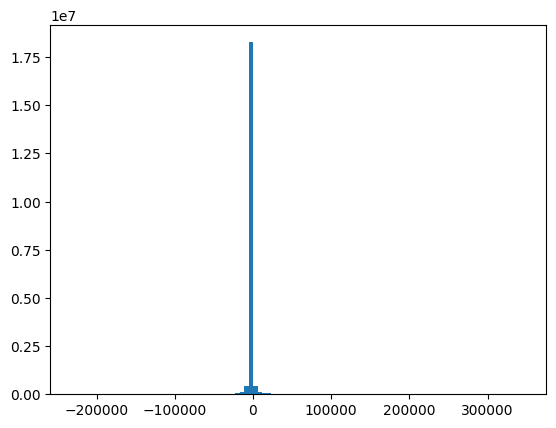

In [6]:
plt.hist(df_transactions['transaction_amt'], bins=100);

(array([6.3366700e+05, 3.3220000e+03, 6.5800000e+02, 8.7430000e+03,
        1.4714110e+06, 1.0251431e+07, 6.6164370e+06, 2.4356900e+05,
        4.1592500e+05, 1.7674700e+05]),
 array([-1.0000e+00,  9.3970e+02,  1.8804e+03,  2.8211e+03,  3.7618e+03,
         4.7025e+03,  5.6432e+03,  6.5839e+03,  7.5246e+03,  8.4653e+03,
         9.4060e+03]),
 <BarContainer object of 10 artists>)

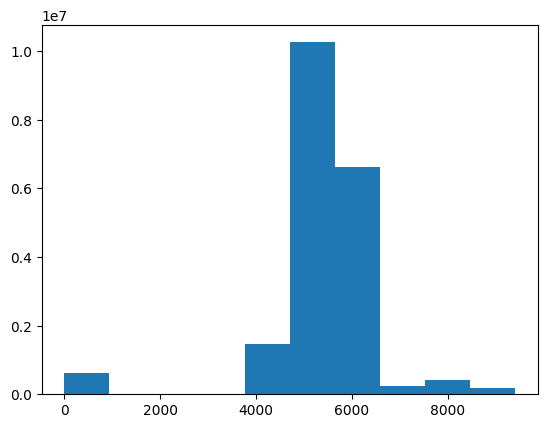

In [7]:
plt.hist(df_transactions['mcc_code']);

In [18]:
df_transactions['currency_rk'].value_counts()

 48    19765158
-1        27405
 50       20364
 60        8983
Name: currency_rk, dtype: int64

In [23]:
df_transactions[df_transactions['currency_rk'] == 48]['transaction_amt'].describe()

count    1.976516e+07
mean    -6.177175e+02
std      9.492894e+03
min     -2.300440e+05
25%     -7.889437e+02
50%     -2.950908e+02
75%     -1.123952e+02
max      3.463953e+05
Name: transaction_amt, dtype: float64

In [25]:
df_transactions['mcc_code'].value_counts()

5411    5665649
5499    1740868
5814    1579958
5921     839260
6011     689507
         ...   
3771          1
3196          1
3056          1
3020          1
3405          1
Name: mcc_code, Length: 386, dtype: int64

In [7]:
df_transactions[(df_transactions['transaction_amt'] > 0)]['mcc_code'].value_counts()

-1       589319
 4829    217710
 6012     34121
 6011     31694
 5691     16686
          ...  
 9406         1
 3770         1
 7393         1
 3366         1
 8241         1
Name: mcc_code, Length: 262, dtype: int64

In [19]:
df_transactions[df_transactions['mcc_code'] == -1].count()

user_id             623291
mcc_code            623291
currency_rk         623291
transaction_amt     623291
transaction_dttm    623291
anomaly             623291
dtype: int64

In [62]:
pos = df_transactions[(df_transactions['mcc_code'] == 5411) & (df_transactions['transaction_amt'] > 0)]['transaction_amt'].quantile(.95)

In [64]:
for mcc in df_transactions['mcc_code'].unique()[:10]:
    print(mcc)

5411
5499
4829
5814
4789
5331
5931
5541
5921
5812


## Anomaly defenition

In [15]:
df_transactions['anomaly'] = 0

In [117]:
def check_by_currency_rk():
    df_transactions.loc[df_transactions['currency_rk'] != 48, 'anomaly'] = 1

def check_by_quantiles():
    for mcc in tqdm(df_transactions['mcc_code'].unique()):
        pos_pos = df_transactions[(df_transactions['mcc_code'] == mcc) & (df_transactions['transaction_amt'] > 0)]['transaction_amt'].quantile(.99)
        pos_neg = df_transactions[(df_transactions['mcc_code'] == mcc) & (df_transactions['transaction_amt'] < 0)]['transaction_amt'].quantile(.1)

        answ = df_transactions[df_transactions['mcc_code'] == mcc]['transaction_amt'].apply(lambda x: int(x > pos_pos or x < pos_neg))
        df_transactions.loc[answ.index, 'anomaly'] = answ

In [119]:
check_by_quantiles()

100%|██████████| 386/386 [01:53<00:00,  3.41it/s]


In [120]:
check_by_currency_rk()

In [121]:
df_transactions['anomaly'].sum()

1949850